In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#!pip install seaborn
#!pip install tensorflow-gpu==2.10.0

In [11]:
data_dir = ('./Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        break

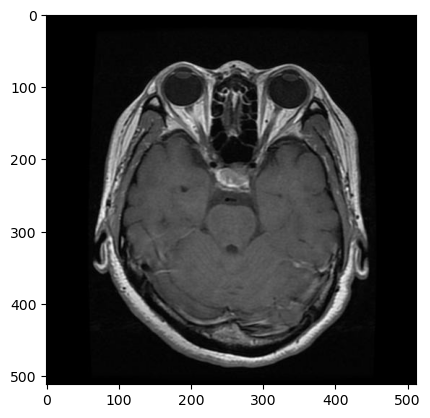

In [12]:
plt.imshow(img_array);

In [13]:
img_array.shape

(512, 512, 3)

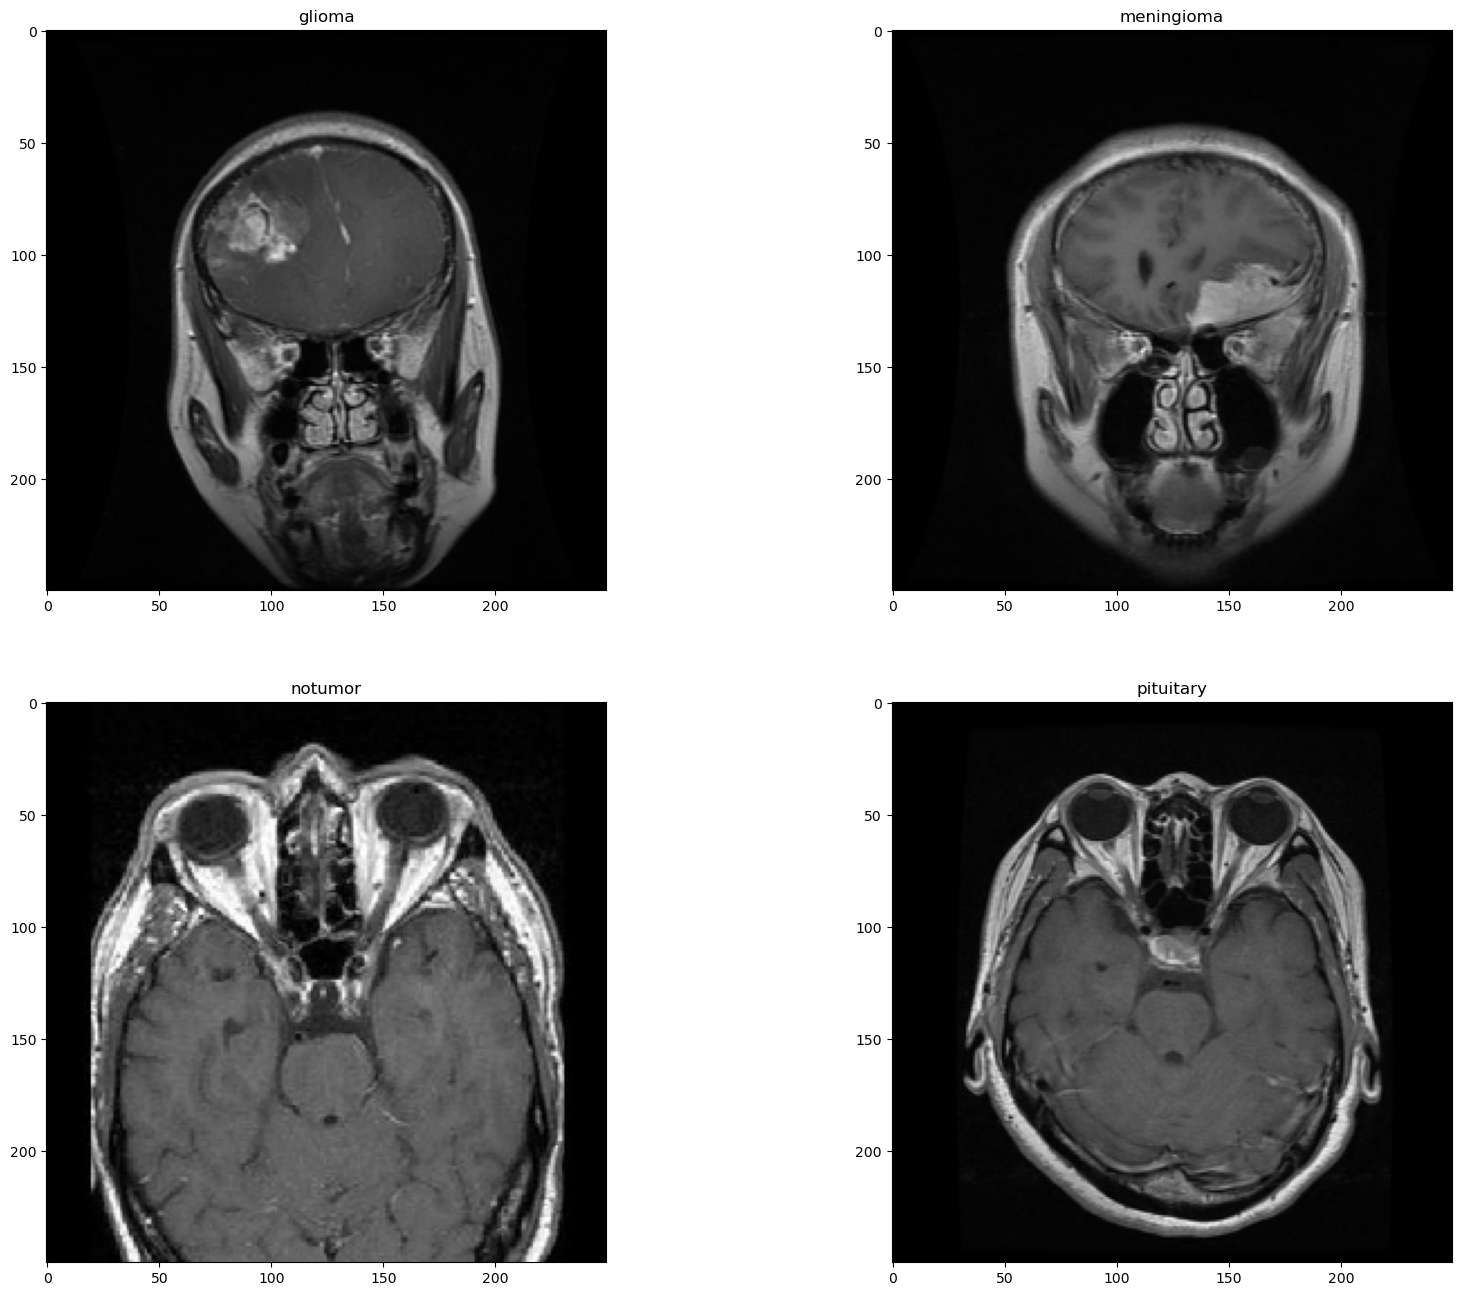

In [14]:
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-glTr_0000.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(categories[i])

In [15]:
# using the ImageDataGenerator to prepare the images (Resize, nomalize, etc)

generator_train = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True) 

generator_test = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [16]:
train = generator_train.flow_from_directory('./Training', target_size=(224,224),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('./Testing', target_size=(224,224),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

Found 5711 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [2]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(32,(3,3), input_shape=(224,224, 1)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
# Neural network

model1.add(Dense(units= 252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

In [ ]:
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = 'model1_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

# Fiting the model.
history1 = model1.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model1_es, model1_rlr, model1_mcp])

In [ ]:
model1.evaluate(test)

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(20,17))

axs[0, 0].plot(history1.history["loss"],c = "purple")
axs[0, 0].plot(history1.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([-0.1,2])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Loss on Model_1 32 Filtters - 3x3 kernel - 2 Conv Layers')

axs[0, 1].plot(history1.history["categorical_accuracy"],c = "purple")
axs[0, 1].plot(history1.history["val_categorical_accuracy"],c = "orange")
axs[0, 1].set_ylim([0.8,1.1])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Accuracy on Model_1 32 Filtters - 3x3 kernel - 2 Conv Layers')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#model1.save(os.path.join('models','cnn224.h5'))

In [ ]:
model = load_model('models/cnn224.h5')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.cm as cm

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (12, 12), fontsize=14):
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix.flatten() / np.sum(confusion_matrix)]

    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(class_names), len(class_names))

    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')

    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

In [ ]:
import math
number_of_examples = len(test.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32)) 
# 1.0 above is to skip integer division

y_test = []

for i in range(0,int(number_of_generator_calls)):
    y_test.extend(np.array(test[i][1]))
y_test=np.array(y_test)

In [ ]:

pred = model.predict(test)
y_test = y_test.argmax(axis=1)

# take the argmax for each set of prediction scores
# to return the class id of the highest confidence prediction
pred_ids = pred.argmax(axis=1)
conf_mat = confusion_matrix(y_test, pred_ids)
figure = print_confusion_matrix(conf_mat, categories)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import sklearn.metrics as skm
print("accuracy=",skm.balanced_accuracy_score(y_test, pred_ids))
print("recall/senstivity=",skm.recall_score(y_test, pred_ids,average='weighted'))
print("precision=",skm.precision_score(y_test, pred_ids,average='weighted'))
print("f1_score=",skm.f1_score(y_test, pred_ids,average='weighted'))